<a href="https://colab.research.google.com/github/korayakan/ba_anhang/blob/master/ANHANG2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Installation von benötigten Bibliotheken

In [0]:
!sudo apt-get -qq install tesseract-ocr
!pip install -q pytesseract

In [0]:
!pip install -q fuzzywuzzy[speedup]

##Download des SROIE 2019

In [3]:
![ -d "ba_dataset" ] && echo "Dataset directory exists."
![ ! -d "ba_dataset" ] \
&& echo "Dataset directory DOES NOT exist. Cloning from Github..." \
&& git clone -q https://github.com/korayakan/ba_dataset.git \
&& rm -rf ba_dataset/.git && echo "Done"

Dataset directory exists.


##Funktionen für den Datensatz

In [0]:
# for image handling
from PIL import Image
# for json
import json
# for glob file search
import glob
# for fuzzy string comparison
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
# for encoding strings
from zlib import crc32
# for log configuration
import logging
# for random numbers
from random import randint

In [0]:
logging.getLogger().setLevel(logging.ERROR)

COORDINATE_PATH = 'ba_dataset/SROIE2019/0325updated.task1train(626p)'
TAG_PATH = 'ba_dataset/SROIE2019/0325updated.task2train(626p)'
IMG_PATH = COORDINATE_PATH
TAG_TO_IDX = {'': 0, 'company': 1, 'date': 2, 'address': 3, 'total': 4}
IDX_TO_TAG = {v: k for k, v in TAG_TO_IDX.items()}

In [0]:
def get_filenames(path, suffix):
    path = path + '/' if not path.endswith('/') else path
    files = glob.glob(path + '*.' + suffix)
    for idx, file in enumerate(files):
        files[idx] = file.split("/")[-1].replace('.txt', '').replace('.jpg', '')
    return files


def get_text_filenames(path):
    return get_filenames(path, 'txt')


def get_image_filenames(path):
    return get_filenames(path, 'jpg')


def prepare_data(filename):
    tags = read_tags(filename)

    im = read_image_file(filename)
    width, height = im.size

    coordinates = read_normalized_coordinates(filename, width, height)
    coordinate_inputs = [coordinates[i][:9] for i in range(len(coordinates))]
    coordinate_texts = [coordinates[i][9] for i in range(len(coordinates))]

    coordinate_tags = match_coordinate_tags(coordinate_texts, tags)
    return tags, coordinate_inputs, coordinate_texts, coordinate_tags


def get_all_filenames():
    image_files = get_image_filenames(IMG_PATH)
    # print('found {} image files'.format(len(image_files)))

    coordinate_files = get_text_filenames(COORDINATE_PATH)
    # print('found {} files with coordinate data'.format(len(coordinate_files)))

    tag_files = get_text_filenames(TAG_PATH)
    # print('found {} files with tag data'.format(len(tag_files)))

    filenames = list(set(image_files) & set(coordinate_files) & set(tag_files))
    filenames.sort()
    return filenames


def prepare_training_data():
    filenames = get_all_filenames()
    print('found {} files with coordinate and tag data'.format(len(filenames)))

    training_size = int(len(filenames) * 0.8)
    print('using {} files for training'.format(training_size))

    training_data = []
    for i in range(training_size):
        tags, coordinate_inputs, coordinate_texts, \
        coordinate_tags = prepare_data(filenames[i])
        training_data.append((coordinate_inputs, coordinate_tags))

    return training_data


def get_random_test_file():
    filenames = get_all_filenames()
    print('found {} files with coordinate and tag data'.format(len(filenames)))

    test_size = int(len(filenames) * 0.2)
    print('using {} files for testing'.format(test_size))
    
    return filenames[randint(test_size + 1, len(filenames) - 1)]


def get_test_files():
    filenames = get_all_filenames()
    print('found {} files with coordinate and tag data'.format(len(filenames)))
    
    training_size = int(len(filenames) * 0.8)
    test_size = int(len(filenames) * 0.2)
    print('using {} files for testing'.format(test_size))

    test_data = []
    for i in range(training_size, len(filenames) - 1):
        tags, coordinate_inputs, coordinate_texts, coordinate_tags = \
        prepare_data(filenames[i])
        test_data.append(filenames[i])

    return test_data


def read_text_file(path, filename):
    path = path + '/' if not path.endswith('/') else path
    with open(path + filename + '.txt') as file:
        text = file.read()
    return text


def read_text_file_lines(path, filename):
    path = path + '/' if not path.endswith('/') else path
    lines = []
    with open(path + filename + '.txt') as file:
        for line in file:
            lines.append(line.rstrip('\n'))
    return lines


def read_coordinates(filename, \
                     path='ba_dataset/SROIE2019/0325updated.task1train(626p)'):
    text = read_text_file_lines(path, filename)
    coordinates = []
    for line in text:
        tokens = line.split(',')
        line_coordinates = list(map(int, tokens[0:8]))
        line_text = ','.join(tokens[8:])
        line_coordinates.append(line_text)
        coordinates.append(line_coordinates)
    return coordinates


def read_normalized_coordinates(filename, width, height, \
    path='ba_dataset/SROIE2019/0325updated.task1train(626p)'):
    coordinates = read_coordinates(filename, path=path)
    for line in coordinates:
        for x in range(0, 8, 2):
            line[x] /= width
        for x in range(1, 8, 2):
            line[x] /= height
        line.append(line[8])
        line[8] = normalize_text(line[8])
    return coordinates


def read_tags(filename, \
              path='ba_dataset/SROIE2019/0325updated.task2train(626p)'):
    return json.loads(read_text_file(path, filename))


def read_image_file(filename, \
                    path='ba_dataset/SROIE2019/0325updated.task1train(626p)'):
    path = path + '/' if not path.endswith('/') else path
    # return cv2.imread(path + filename + '.jpg', 0)
    return Image.open(path + filename + '.jpg')


def match_coordinate_tags(coordinate_texts, tags):

    tags_reverted = {v: k for k, v in tags.items()}
    tag_values = list(tags.values())
    coordinate_tags = []
    for text in coordinate_texts:
        tag_guess = process.extractOne(text, tag_values, \
                                       scorer=fuzz.partial_ratio, \
                                       score_cutoff=90)
        tag = ''
        if tag_guess is not None:
            tag = tags_reverted[tag_guess[0]]
        coordinate_tags.append(encode_tag(tag))
    return coordinate_tags


def encode_tag(tag):
    return TAG_TO_IDX[tag]


def decode_tag(tag_idx):
    return IDX_TO_TAG[tag_idx]


def normalize_text(input_text, encoding="utf-8"):
    return float(crc32(input_text.encode(encoding)) & 0xffffffff) / 2**32


def combine_predicted_tags(texts, tags):
    company = ''
    date = ''
    address = ''
    total = ''

    for i in range(len(tags)):
        if tags[i] == 1 and not company.endswith(texts[i]):
            company += ' ' + texts[i]
        if tags[i] == 2 and not date.endswith(texts[i]):
            date += ' ' + texts[i]
        if tags[i] == 3 and not address.endswith(texts[i]):
            address += ' ' + texts[i]
        if tags[i] == 4 and not total.endswith(texts[i]):
            total += ' ' + texts[i]

    return {'company': company.strip(), 'date': date.strip(), \
            'address': address.strip(), 'total': total.strip()}

##Definition des LSTM Netzes 

In [0]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as fn

In [0]:
SERIALIZED_MODEL_NAME = 'ba_model.pt'

INPUT_SIZE = 9
OUTPUT_SIZE = 5


class LSTM(nn.Module):

    def __init__(self, hidden_size=6, num_of_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size

        # The LSTM takes coordinates as input, and outputs hidden states
        self.lstm = nn.LSTM(INPUT_SIZE, hidden_size, num_layers=num_of_layers)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_size, OUTPUT_SIZE)

    def forward(self, input_seq):
        hidden_space, _ = self.lstm(input_seq)
        tag_space = self.hidden2tag(hidden_space.view(len(input_seq), -1))
        tag_scores = fn.log_softmax(tag_space, dim=1)
        return tag_scores


def load_model(model_path=SERIALIZED_MODEL_NAME):
    if os.path.isfile(model_path):
        model = torch.load(model_path)
        model.eval()
        return model
    else:
        print('Model was not trained yet!')
        sys.exit(0)


def evaluate(coordinate_inputs, model_path=SERIALIZED_MODEL_NAME):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # print('Using {} for prediction'.format(device))
    with torch.no_grad():
        model = load_model(model_path)
        model.to(device)
        input_seq = torch.tensor(coordinate_inputs)
        input_seq = input_seq.unsqueeze(1)
        input_seq = input_seq.to(device)
        tag_scores = model(input_seq)
        probabilities, tags = tag_scores.topk(1)
        predictions = []
        for i in range(len(probabilities)):
            predictions.append((torch.exp(probabilities[i]).item(), \
                                tags[i].item()))
        return predictions

##Funktionen für das Training

In [0]:
def train(epochs, print_every=1, learning_rate=0.1, hidden_size=6, \
          num_of_layers=1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using {} for training'.format(device))

    model = LSTM(hidden_size=hidden_size, num_of_layers=num_of_layers)
    loss_function = nn.NLLLoss()
    optimizer = opt.SGD(model.parameters(), lr=learning_rate)
    model.to(device)

    data_set = prepare_training_data()
    split_data = {0: [], 1: [], 2: [], 3: []}
    for i in range(len(data_set)):
        if i % 4 == 0:
            split_data[0].append(data_set[i])
        if i % 4 == 1:
            split_data[1].append(data_set[i])
        if i % 4 == 2:
            split_data[2].append(data_set[i])
        if i % 4 == 3:
            split_data[3].append(data_set[i])
    # for i in range(4):
    #     print(len(split_data[i]))

    steps = 0
    running_loss = 0
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        steps += 1
        validation_idx = epoch % 4
        validation_data = split_data[validation_idx]
        training_data = []
        for i in range(4):
            if i != validation_idx:
                training_data.extend(split_data[i])

        for coordinate_inputs, coordinate_tags in training_data:
            # print(coordinate_inputs)
            # print(coordinate_tags)

            # Step 1. Clear Pytorch gradients
            model.zero_grad()

            # Step 2. Get inputs ready for the network
            input_seq = torch.tensor(coordinate_inputs)
            input_seq = input_seq.unsqueeze(1)
            input_seq = input_seq.to(device)
            targets = torch.tensor(coordinate_tags)
            targets = targets.to(device)
            # print(input_seq)
            # print(targets)

            # Step 3. Run forward pass
            tag_scores = model(input_seq)

            # Step 4. Compute the loss, gradients, and update the parameters
            loss = loss_function(tag_scores, targets)
            # print(loss)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        if (steps % print_every == 0):
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for coordinate_inputs_val, coordinate_tags_val \
                in validation_data:
                    input_seq_val = torch.tensor(coordinate_inputs_val)
                    input_seq_val = input_seq_val.unsqueeze(1)
                    input_seq_val = input_seq_val.to(device)
                    targets_val = torch.tensor(coordinate_tags_val)
                    targets_val = targets_val.to(device)

                    tag_scores_val = model.forward(input_seq_val)
                    loss_val = loss_function(tag_scores_val, targets_val)
                    test_loss += loss_val.item()

            train_losses.append(running_loss / (len(training_data) \
                                                * print_every))
            test_losses.append(test_loss / len(validation_data))
            print_trainloss=running_loss / (len(training_data) * print_every)
            print(f"Epoch {epoch + 1}/{epochs}.. "
                  f"Train loss: {print_trainloss:.3f}.. "
                  f"Test loss: {test_loss / len(validation_data):.3f}.. ")
                  #f"Test accuracy: {accuracy / len(testloader):.3f}")
            running_loss = 0
            model.train()

    torch.save(model, SERIALIZED_MODEL_NAME)
    return train_losses, test_losses

##Funktionen für die Vorhersage

In [0]:
def predict(filename, model_path=SERIALIZED_MODEL_NAME):
    print('File:')
    print(filename, '\n')

    tags, coordinate_inputs, coordinate_texts, coordinate_tags = \
    prepare_data(filename)

    print('Expected category tags:')
    print(tags, '\n')

    # print('Input coordinates:')
    # print(coordinate_inputs)
    print(coordinate_inputs)
    print(coordinate_texts)
    print('Expected coordinate tags:')
    print(coordinate_tags)

    predictions = evaluate(coordinate_inputs, model_path)
    predicted_coordinate_tags = []
    for prediction in predictions:
        predicted_coordinate_tags.append(prediction[1])
    probabilities = []
    for prediction in predictions:
        probabilities.append("{:.0%}".format(prediction[0]))
    print('Predicted coordinate tags:')
    print(predicted_coordinate_tags)
    print('Confidence:')
    print(probabilities, '\n')

    predicted_tags = combine_predicted_tags(coordinate_texts, \
                                            predicted_coordinate_tags)
    print(predicted_tags)


def get_expected_tags(filename):
    tags, coordinate_inputs, coordinate_texts, coordinate_tags = \
    prepare_data(filename)
    return coordinate_tags


def get_predicted_tags(filename, model_path=SERIALIZED_MODEL_NAME):
    tags, coordinate_inputs, coordinate_texts, coordinate_tags = \
    prepare_data(filename)
    predictions = evaluate(coordinate_inputs, model_path)
    predicted_coordinate_tags = []
    for prediction in predictions:
        predicted_coordinate_tags.append(prediction[1])
    return predicted_coordinate_tags

##OCR-Modul

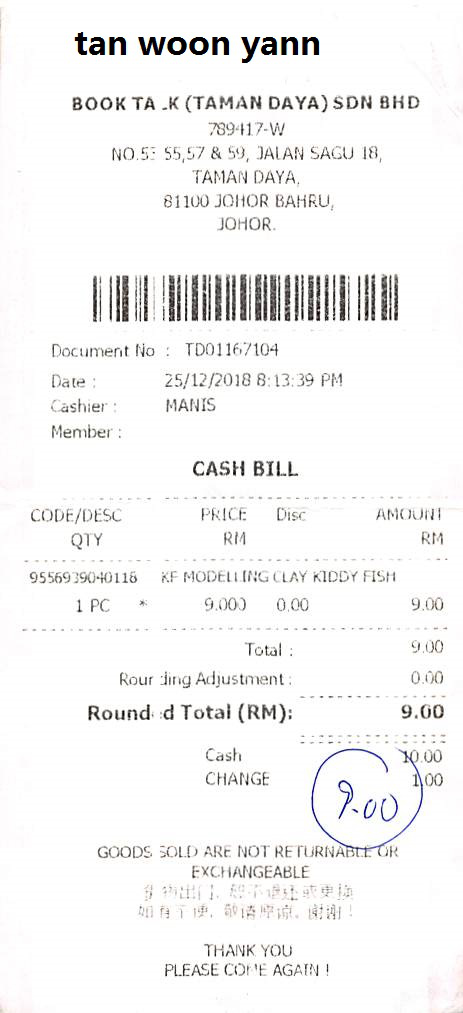

In [11]:
img = read_image_file('X00016469612')
img

In [12]:
import pytesseract
print(pytesseract.image_to_string(img, lang='eng', config='--oem 1'))

tan woon yann

BOOK TA -K (TAMAN DAYA) SDN BHD
PBONT-W
NO.5? $5,57 & 59, JALAN SAGU 18,
TAMAN DAYA
81100 JOHOR BAHRU.
JOHOR.

LAM MITA A

Document Ho : TDO1167104

 

 

Date 25/12/2018 8:13:39 PM
Cashier MANIS
Member
CASH BILL
CODE/DESC PRICE Dise AMOUNT
Quy RM RM
9556929040118 AF MODELLING CLAY KIDDY FISH
1PC + 9.00) 0,00 9.00
Total : 9,00
Rour ding Adjustment 0.00
Round. :d Total (RM): 9.00
Cash oy 40.00.
CHANGE 00

  

GOODS SOLD ARE NOT RETURNAP
EXCHANGEABLE

 

THANK YOU
PLEASE COME AGAIN t


Der folgende Funktionsaufruf gibt für jedes Wort Details inklusive des Konfidenzlevels und der Koordinaten aus

In [0]:
#print(pytesseract.image_to_data(img, lang='eng', config='--oem 1'))

##KI-Modul

###Training des KI-Moduls
Als Hyperparameter werden verwendet:


*   Epoch: 1000
*   Lernrate: 0,05
* Anzahl der Knoten pro Schicht: 256
* Anzahl der Schichten: 3



In [14]:
from datetime import datetime, timezone
import time
start = time.time()
now = datetime.now(timezone.utc).astimezone()
print('start model training at {}'.format(now))

start model training at 2019-08-14 19:58:20.313189+00:00


In [15]:
train_losses, test_losses = train(1000, print_every = 100, \
                                   learning_rate = 0.05, hidden_size=256, \
                                   num_of_layers=3)
#train_losses, test_losses = train(10, print_every = 1, \
#                                 learning_rate = 0.05, hidden_size=256, \
#                                  num_of_layers=1)

Using cuda for training
found 667 files with coordinate and tag data
using 533 files for training
Epoch 100/1000.. Train loss: 0.617.. Test loss: 0.563.. 
Epoch 200/1000.. Train loss: 0.462.. Test loss: 0.367.. 
Epoch 300/1000.. Train loss: 0.214.. Test loss: 0.192.. 
Epoch 400/1000.. Train loss: 0.066.. Test loss: 0.133.. 
Epoch 500/1000.. Train loss: 0.154.. Test loss: 0.202.. 
Epoch 600/1000.. Train loss: 0.074.. Test loss: 0.050.. 
Epoch 700/1000.. Train loss: 0.019.. Test loss: 0.027.. 
Epoch 800/1000.. Train loss: 0.012.. Test loss: 0.007.. 
Epoch 900/1000.. Train loss: 0.006.. Test loss: 0.006.. 
Epoch 1000/1000.. Train loss: 0.005.. Test loss: 0.005.. 


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [16]:
now = datetime.now(timezone.utc).astimezone()
done = time.time()
elapsed = int(round(done - start))
print('training finished at {}, duration was {} min {} sec'\
      .format(now, int(round(elapsed / 60)), elapsed % 60))

training finished at 2019-08-14 20:34:55.714410+00:00, duration was 37 min 35 sec


###Schaubild des Lernverlaufs

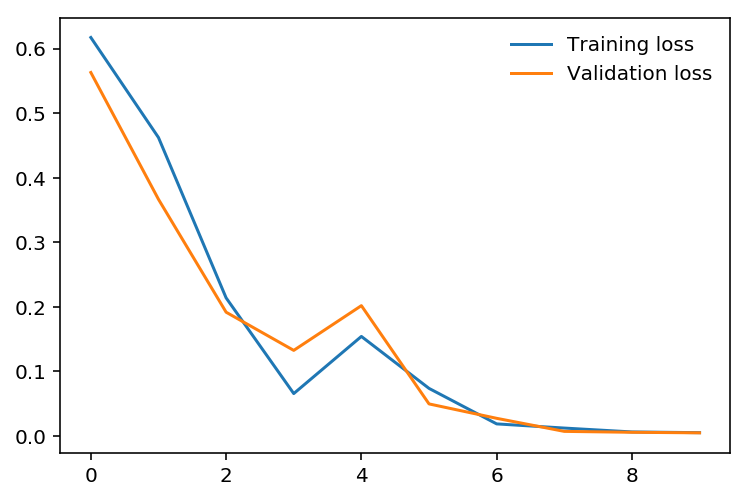

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

Das gespeicherte Model kann für Vorhersagen verwendet werden

In [0]:
#predict(get_random_test_file())

##Evaluierung des KI-Moduls

In [0]:
from sklearn import metrics

In [20]:
expected = []
predicted = []
for filename in get_test_files():
  #print('File: ' + filename)
  expected.extend(get_expected_tags(filename))
  predicted.extend(get_predicted_tags(filename, 'ba_model.pt'))

print()
print("Konfusionsmatrix")
print(metrics.confusion_matrix(expected, predicted))
print()
print("Evaluierungskennzahlen")
print(metrics.classification_report(expected, predicted, digits=3))

found 667 files with coordinate and tag data
using 133 files for testing

Konfusionsmatrix
[[5059   15   56   63  142]
 [  74  160    7    8    1]
 [ 199    1  199   13   15]
 [  81    5    9  318    0]
 [ 252    1    0    1  216]]

Evaluierungskennzahlen
              precision    recall  f1-score   support

           0      0.893     0.948     0.920      5335
           1      0.879     0.640     0.741       250
           2      0.734     0.466     0.570       427
           3      0.789     0.770     0.779       413
           4      0.578     0.460     0.512       470

    accuracy                          0.863      6895
   macro avg      0.775     0.657     0.704      6895
weighted avg      0.855     0.863     0.855      6895

